In [1]:
import os
import datetime as dt#デフォはUTCの国際基準時間
import pytz#日本時間に変換
import time
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm # version 0.8.0以上
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_error,r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import regularizers
from keras.models import load_model
from keras import backend as K
from keras.utils import plot_model
from IPython.display import Image

from google.colab import files

In [2]:
path = 'COVID-19'
if not os.path.exists(path):
  !git clone https://github.com/CSSEGISandData/COVID-19.git
else:
  print("Dude!! This file is already download")

Dude!! This file is already download


2020-01-22         2
2020-01-23         2
2020-01-24         2
2020-01-25         2
2020-01-26         4
               ...  
2020-11-10    110487
2020-11-11    112011
2020-11-12    113655
2020-11-13    115360
2020-11-14    117113
Name: 151, Length: 298, dtype: int64


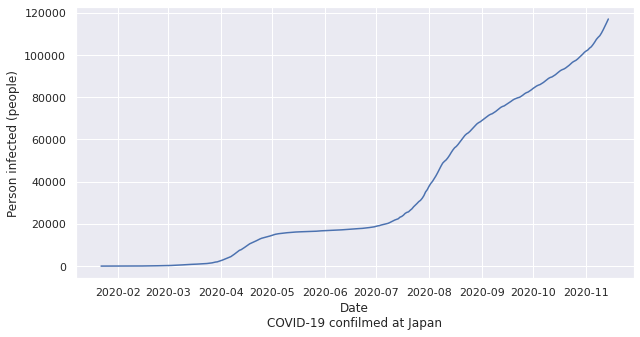

In [3]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region']=='Japan']
df = df.iloc[:,4:].copy()
data_at_japan = df.iloc[0,:]
data_at_japan.index = pd.to_datetime(data_at_japan.index)
print(data_at_japan)

plt.figure(figsize=(10,5))
plt.plot(data_at_japan)
plt.title('COVID-19 confilmed at Japan', y = -0.2)
plt.xlabel("Date")
plt.ylabel("Person infected (people)")
plt.grid(True)
plt.show()

#ファイル保存
fname ='original.png'
plt.savefig(fname) 
plt.close()

2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
2020-01-27      0.0
              ...  
2020-10-24    731.0
2020-10-25    496.0
2020-10-26    408.0
2020-10-27    643.0
2020-10-28    731.0
Name: 151, Length: 280, dtype: float64


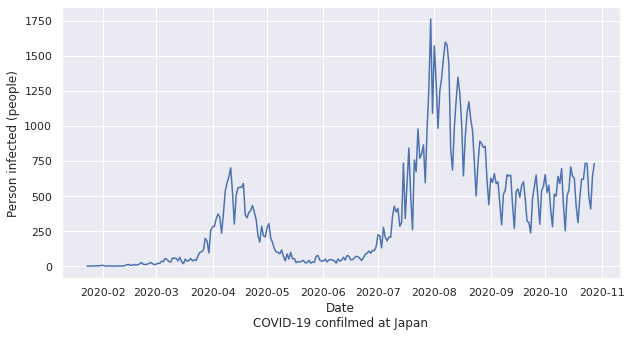

In [4]:
data_at_japan_diff = data_at_japan - data_at_japan.shift(1) # 階差系列データの作成
data_at_japan_diff = data_at_japan_diff.dropna()
data_at_japan_diff = data_at_japan_diff['2020-01-23':'2020-10-28']#10-28
print(data_at_japan_diff)

plt.figure(figsize=(10,5))
plt.plot(data_at_japan_diff)
plt.title('COVID-19 confilmed at Japan', y=-0.2)
plt.xlabel("Date")
plt.ylabel("Person infected (people)")
plt.grid(True)
plt.show()

#ファイル保存
fname ='diff.png'
plt.savefig(fname) 
plt.close()

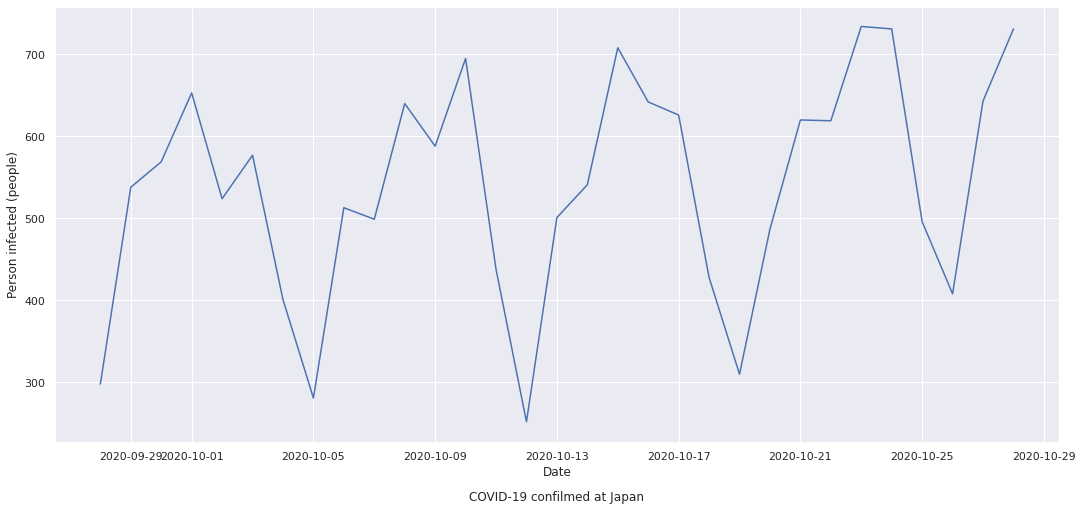

In [5]:
hoge=data_at_japan_diff[-31:]
#print(hoge)
plt.figure(figsize=(18,8))
plt.title('COVID-19 confilmed at Japan', y=-0.15)
plt.xlabel("Date")
plt.ylabel("Person infected (people)")
plt.plot(hoge)
plt.grid(True)
plt.show()

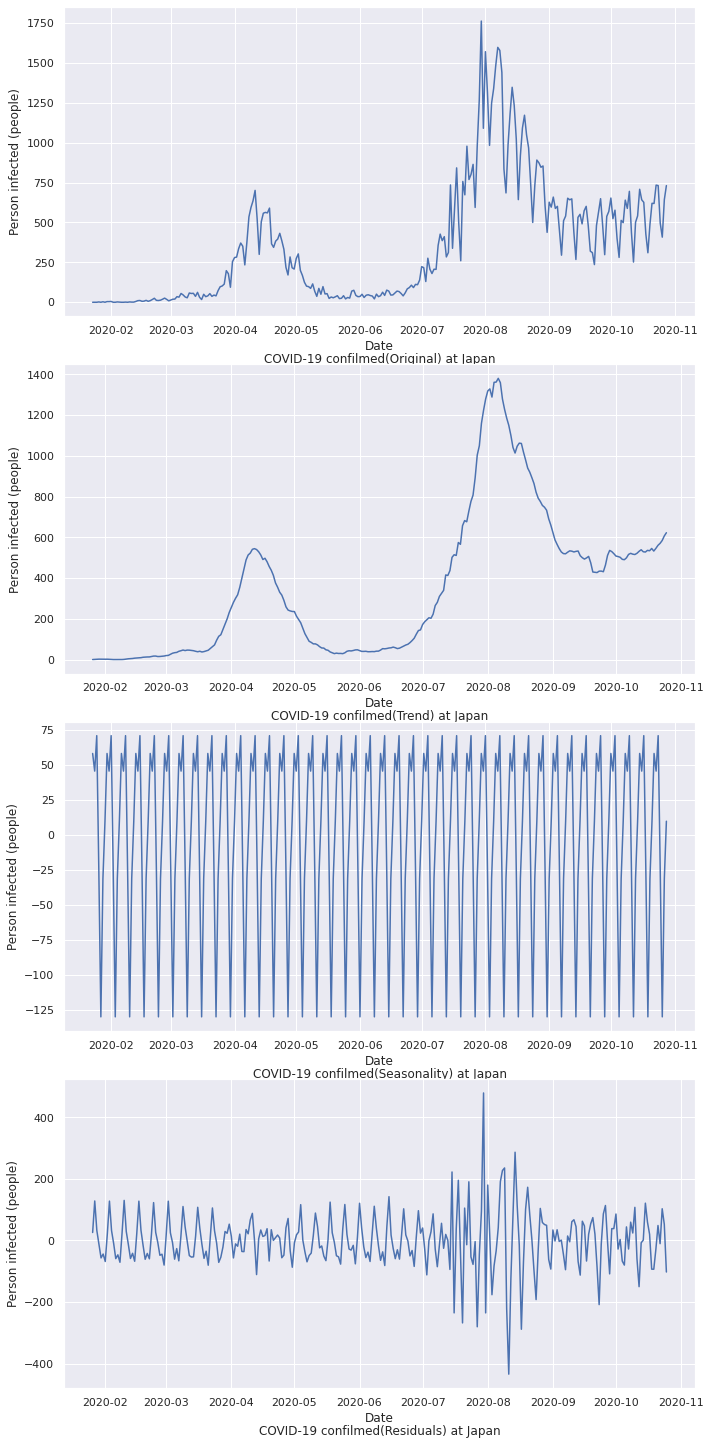

In [6]:
res = sm.tsa.seasonal_decompose(data_at_japan_diff)#データを分解

original = data_at_japan_diff # オリジナルデータ
trend_original = res.trend # トレンドデータ
seasonal_original = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(10, 20)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.title('COVID-19 confilmed(Original) at Japan', y=-0.17)
plt.xlabel("Date")
plt.ylabel("Person infected (people)")
plt.grid(True)
# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend_original)
plt.title('COVID-19 confilmed(Trend) at Japan', y=-0.17)
plt.xlabel("Date")
plt.ylabel("Person infected (people)")
plt.grid(True)
# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal_original)
plt.title('COVID-19 confilmed(Seasonality) at Japan', y=-0.17)
plt.xlabel("Date")
plt.ylabel("Person infected (people)")
plt.grid(True)
# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.title('COVID-19 confilmed(Residuals) at Japan', y=-0.17)
plt.xlabel("Date")
plt.ylabel("Person infected (people)")
plt.grid(True)

plt.tight_layout() # グラフの間隔を自動調整

fname ='decompose.png'
plt.savefig(fname) 

In [7]:
y = data_at_japan_diff.values.astype(float)
print(len(y))

test_size = 7
train_original_data = y[:-test_size]#0から後ろから4個目までを取り出す。　つまり学習用のデータ(学習の範囲)は直近３日間前
test_original_data = y[-test_size:]#最後から３つを取り出す。　検証用データは直近３日間前

scaler = MinMaxScaler(feature_range=(-1,1))#feature_rangeは引数に正規化変換後の最大値と最小値を決める。今回は−１から１で正規化
train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))#学習用データに正規化の適用　またskleranの入力形状に適用 合わせた行と１列

280


In [8]:
def sequence_creator(input_data,window_size):#train_normalizedとwindow_sizeを渡し訓練データと正解ラベルを返す

    data, target = [], []
    data_len = len(input_data)
    for i in range(data_len - window_size):#data_lenのままだとwindowが配列を超えてしまう
        window_fr = input_data[i:i+window_size]#iを始点にwindow数取り出す
        correct_label = input_data[i+window_size:i+window_size+1]#index番号がi+windowの値を取り出す。つまりwindowの後にある正解ラベルを取り出す。
        data.append(window_fr)
        target.append(correct_label)

    re_data = np.array(data).reshape(len(data), window_size, 1)#kerasのRNNでは入力をサンプル数,時系列数(window数),入力層のニューロン数にする。　本来なら−１でなくlen(data)?
    re_target = np.array(target).reshape(len(target), 1)#入力と同じにする必要がある。

    return re_data, re_target

window = 7#学習時のウィンドウサイズ
study_data, correct_data  = sequence_creator(train_normalized, window)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 7, 256)            512       
_________________________________________________________________
flatten_19 (Flatten)         (None, 1792)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 1793      
_________________________________________________________________
activation_19 (Activation)   (None, 1)                 0         
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________
None


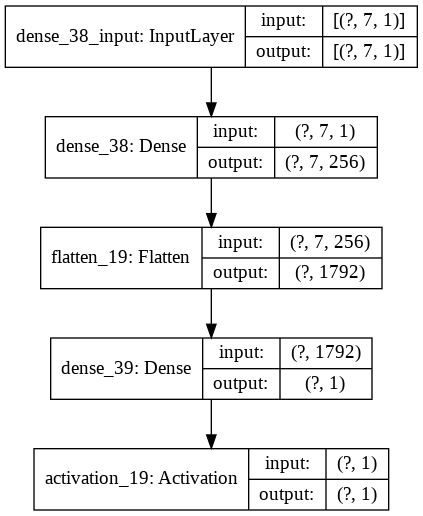

In [114]:
n_in_out = 1
n_hidden = 256#1028

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

tf.random.set_seed(0)
#np.random.seed(0)

model = Sequential()
model.add(Dense(n_hidden, batch_input_shape=(None, window, n_in_out),activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.2)) # 0.15
model.add(Flatten())
model.add(Dense(n_in_out))
model.add(Activation("linear"))
#SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9,beta_2=0.999,amsgrad=False)
model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=["mae"])#,rmse])# optimizer="rmsprop"
print(model.summary())

filename = 'mlp.png';
plot_model(model, show_shapes=True, show_layer_names=True, to_file=filename)
Image(retina=False, filename=filename)

In [115]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=1)
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    x = 0.001
    if epoch >= 200:
        x = 0.0001
    return x


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

epochs = 180#100
start_time = time.time()
history = model.fit(study_data, correct_data, batch_size=2, epochs=epochs, validation_split=0.1, shuffle=True, verbose=0, callbacks=[])#lr_decay,
print("学習時間:",time.time() - start_time)

学習時間: 22.2893545627594


In [37]:
model.save('covid19_mlp_model.h5')
files.download('covid19_mlp_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

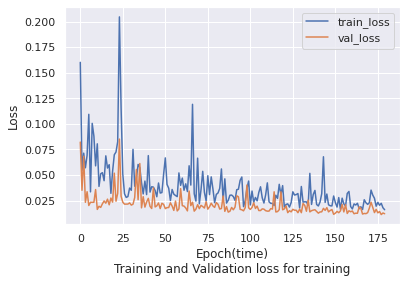

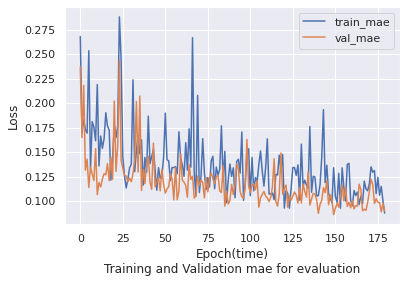

In [116]:
# === 学習推移の可視化 ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
plt.title('Training and Validation loss for training', y=-0.25)
plt.xlabel("Epoch(time)")
plt.ylabel("Loss")
#plt.ylim((0, 0.06))#add
plt.legend()
plt.grid(True)
plt.show()

train_mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(np.arange(len(train_mae)), train_mae, label="train_mae")
plt.plot(np.arange(len(val_mae)), val_mae, label="val_mae")
plt.title('Training and Validation mae for evaluation', y=-0.25)
plt.xlabel("Epoch(time)")
plt.ylabel("Loss")
#plt.ylim((0, 0.2))#add
plt.legend()
plt.grid(True)
plt.show()

# train_rmse = history.history['rmse']
# val_rmse = history.history['val_rmse']

# plt.plot(np.arange(len(train_loss)), train_rmse, label="train_rmse")
# plt.plot(np.arange(len(val_loss)), val_rmse, label="val_rmse")
# plt.title('Training and Validation rmse for evaluation', y=-0.25)
# plt.xlabel("Epoch(time)")
# plt.ylabel("Loss")
# plt.ylim((0, 0.2))#add
# plt.legend()
# plt.show()

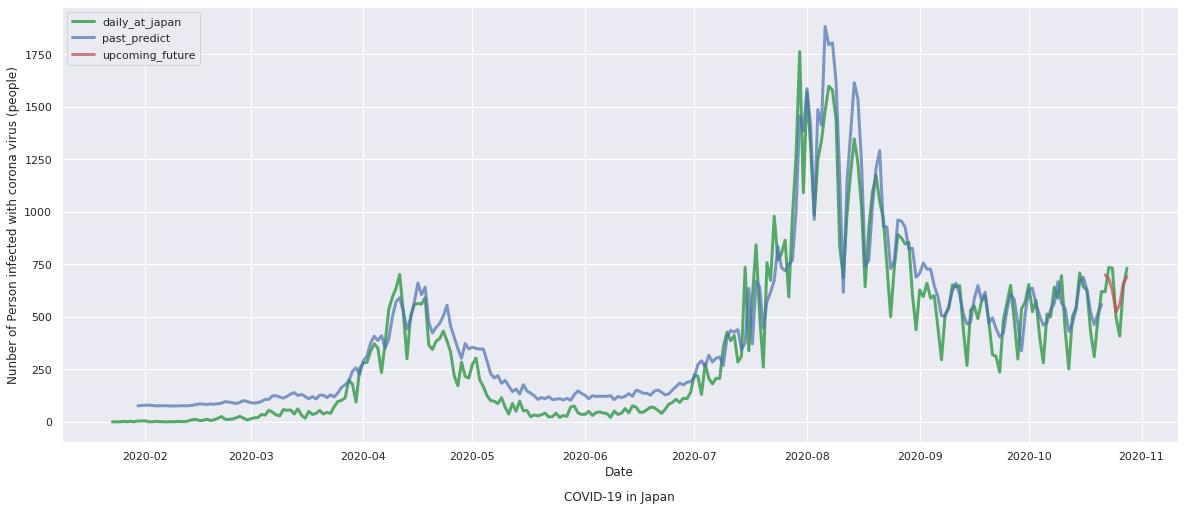

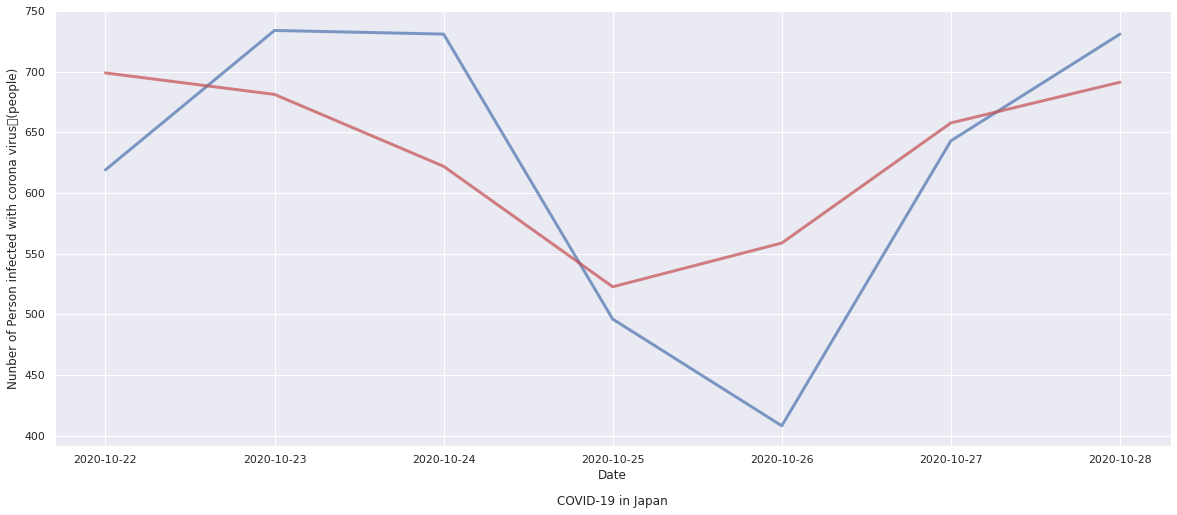

In [117]:
#training predictions
predicted_past_data = model.predict(study_data)
train_inverse= scaler.inverse_transform(predicted_past_data)

#test predictions
upcoming_future=7
predictions = train_normalized[-window:].tolist()
predictions = np.array(predictions).reshape(-1, window, 1)
#予測をfor文で
for i in range(upcoming_future):
  predicted_future = model.predict(predictions)
  with open("in_out.txt",mode="a", encoding= "utf-8") as f:
    f.write("input to model:" + str(predictions) )
    f.write("output from model:" + str(predicted_future) )
  predictions = predictions.tolist()
  predictions = np.append(predictions, predicted_future)
  predictions = predictions[-window:]
  predictions = np.array(predictions).reshape(-1, window, 1)

predictions_infected_pepole = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
#print(predictions_infected_pepole)

x_all =np.arange('2020-01-23','2020-10-29', dtype='datetime64[D]').astype('datetime64[D]')
x_past_predict = np.arange('2020-01-30','2020-10-22', dtype='datetime64[D]').astype('datetime64[D]')#23-26
x_train = np.arange('2020-01-23','2020-10-22', dtype='datetime64[D]').astype('datetime64[D]')
x_test = np.arange('2020-10-22', '2020-10-29', dtype='datetime64[D]').astype('datetime64[D]')

sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in Japan", y=-0.15)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Nunber of Person infected with corona virus (people)")
plt.plot(x_all,data_at_japan_diff,'g',lw=3,label='daily_at_japan')
#plt.plot(x_train,train_original_data,label='train_data')
#plt.plot(x_test,test_original_data,label='test_data')
plt.plot(x_past_predict,train_inverse,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')#+8かも
plt.plot(x_test, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.legend(loc='upper left')
plt.show()

sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in Japan", y=-0.15)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Nunber of Person infected with corona virus　(people)")
plt.plot(x_test,test_original_data,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')
plt.plot(x_test, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.show()

In [118]:
train_data = train_original_data[7:]
train_mae = mean_absolute_error(train_data, train_inverse)
train_mse = mean_squared_error(train_data, train_inverse)
train_rmse = np.sqrt(mean_squared_error(train_data, train_inverse))
train_r2 = r2_score(train_data, train_inverse)

test_mae = mean_absolute_error(test_original_data, predictions_infected_pepole)
test_mse = mean_squared_error(test_original_data, predictions_infected_pepole)
test_rmse = np.sqrt(mean_squared_error(test_original_data, predictions_infected_pepole))
test_r2 = r2_score(test_original_data, predictions_infected_pepole)

print('train_mae:'+str(train_mae))
print('train_mse:'+str(train_mse))
print('train_rmae:'+str(train_rmse))
print('train_r2:'+str(train_r2))
print('')
print('test_mae:'+str(test_mae))
print('test_mse:'+str(test_mse))
print('test_rmse:'+str(test_rmse))
print('test_r2:'+str(test_r2))#r2 最も当てはまりの良い場合、1.0 となります (当てはまりの悪い場合、マイナスとなることもあります)

train_mae:96.50342149662792
train_mse:13843.470088674298
train_rmae:117.65827675380214
train_r2:0.9020011684966043

test_mae:67.6442608258554
test_mse:6611.287165081056
test_rmse:81.30982207015987
test_r2:0.5297749689534355


159日間後


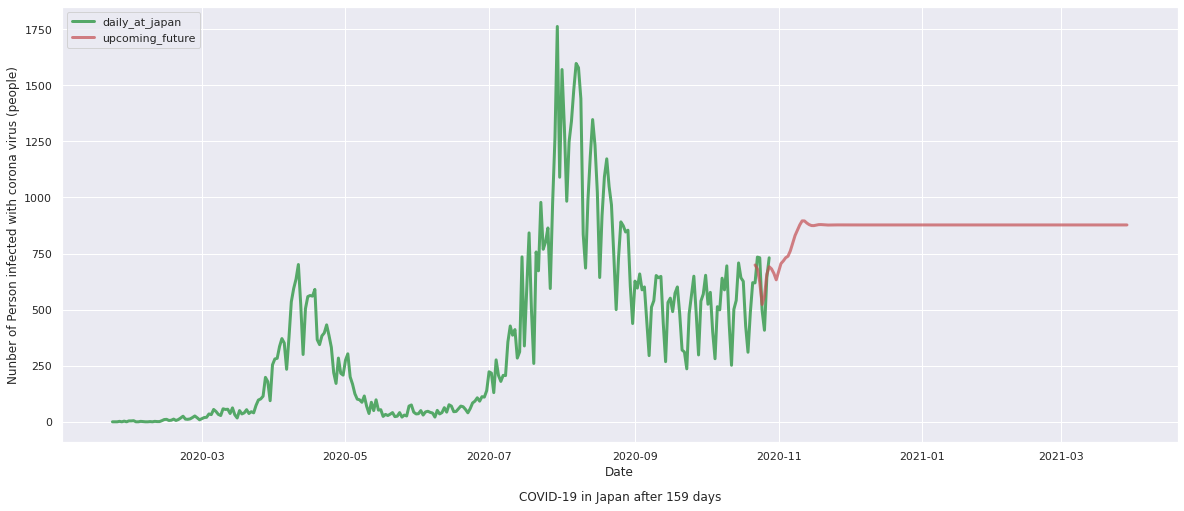

In [119]:
#long term predictions
x_long_term = np.arange('2020-10-22', '2021-03-30', dtype='datetime64[D]').astype('datetime64[D]')#11-21
long_term_future = len(x_long_term)
print(str(long_term_future) + '日間後')

predictions2 = train_normalized[-window:].tolist()
predictions2 = np.array(predictions2).reshape(-1, window, 1)

long_term_predictions = []
#予測をfor文で
for i in range(long_term_future):
  predicted_long_term_future = model.predict(predictions2)
  long_term_predictions.append(predicted_long_term_future)
  # with open("in_out_long_term.txt",mode="a", encoding= "utf-8") as f:
  #   f.write("input to model:" + str(predictions) )
  #   f.write("output from model:" + str(predicted_future) )
  predictions2 = predictions2.tolist()
  predictions2 = np.append(predictions2, predicted_long_term_future)
  predictions2 = predictions2[-window:]
  predictions2 = np.array(predictions2).reshape(-1, window, 1)

predictions_infected_pepole_long_term = scaler.inverse_transform(np.array(long_term_predictions).reshape(-1,1))
#print(predictions_infected_pepole_long_term)


sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in Japan after " + str(long_term_future) + ' days', y=-0.15)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Nunber of Person infected with corona virus (people)")
plt.plot(x_all,data_at_japan_diff,'g',lw=3,label='daily_at_japan')
plt.plot(x_long_term, predictions_infected_pepole_long_term, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.legend(loc='upper left')
plt.show()